# Qredo tokenomics simulation - scenario generation

#### June 2023

## 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechaqredo.params import default_params_dict
from mechaqredo.sim import run_param_sweep_sim

from mechaqredo.generate_scenarios import generate_params_dict_for_scenario
from mechaqredo.data_models import build_model_data_dict_samples

## 2. Set up parameters

In [3]:
forecast_length = 365*2
data_dict_n_samples = 50

file = os.path.realpath("../data/balances.csv")
outfolder = os.path.realpath("../data/sim_data")
wallet_df = pd.read_csv(file)
params_dict = default_params_dict(forecast_length)
params_dict["wallet_balances_vec"] = wallet_df["balance"].values

In [4]:
scenarios = ['pessimistic', 'base', 'optimistic']
scenario_tuple_list = list(itertools.product(scenarios, scenarios, scenarios))
len(scenario_tuple_list)

27

## 3. Build scenarios and save

In [5]:
scenario_dict_list = []
for token_scenario, usage_scenario, staking_scenario in scenario_tuple_list:
    scenario_params_dict = generate_params_dict_for_scenario(
        params_dict, token_scenario, usage_scenario, staking_scenario
    )
    data_dict_list = build_model_data_dict_samples(
            data_dict_n_samples, forecast_length, scenario_params_dict
        )
    scenario_dict = {
        "token_scenario":token_scenario, 
        "usage_scenario": usage_scenario, 
        "staking_scenario": staking_scenario,
        "params_dict": scenario_params_dict,
        "data_dict_list": data_dict_list,
    }
    scenario_dict_list.append(scenario_dict)
output_file = os.path.join(outfolder, f"params_scenarios.pickle")
with open(output_file, "wb") as fp:
    pickle.dump(scenario_dict_list, fp)

## 4. Plot scenarios

In [6]:
scenarios_df_list = []
for scenario_dict in scenario_dict_list:
    params_dict = scenario_dict["params_dict"]
    raw_df = pd.DataFrame((scenario_dict["data_dict_list"]))
    temp_df = raw_df.explode(['n_txs', 'token_price', 'service_fees', 'n_validators'])
    temp_df['token_scenario'] = scenario_dict['token_scenario']
    temp_df['usage_scenario'] = scenario_dict['usage_scenario']
    temp_df['staking_scenario'] = scenario_dict['staking_scenario']
    temp_df["iteration"] = list(np.arange(forecast_length))*50
    temp_df["date"] = temp_df["iteration"].apply(lambda x: params_dict["sim_start_datetime"]+dt.timedelta(days=x)).values
    scenarios_df_list.append(temp_df)
scenarios_df = pd.concat(scenarios_df_list, ignore_index=True)
scenarios_df.head()

,n_txs,token_price,service_fees,n_validators,token_scenario,usage_scenario,staking_scenario,iteration,date
0,8000,0.095,3000.0,6.0,pessimistic,pessimistic,pessimistic,0,2023-06-15
1,7983,0.094083,2908.530804,6.0,pessimistic,pessimistic,pessimistic,1,2023-06-16
2,7967,0.092191,2915.272621,6.0,pessimistic,pessimistic,pessimistic,2,2023-06-17
3,7950,0.089821,3002.23503,6.0,pessimistic,pessimistic,pessimistic,3,2023-06-18
4,7934,0.091297,3027.054624,6.0,pessimistic,pessimistic,pessimistic,4,2023-06-19


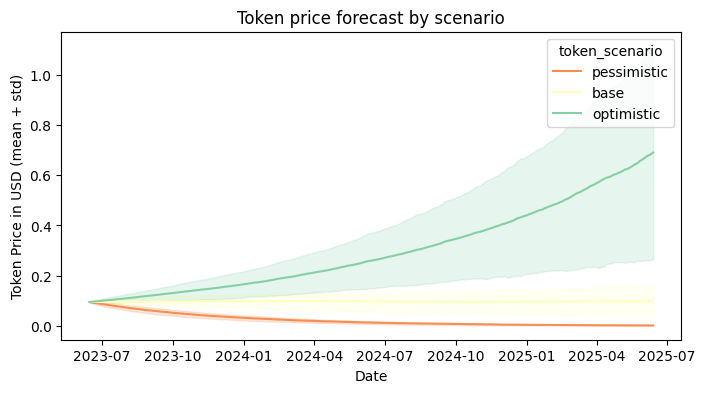

In [7]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=scenarios_df, x="date", y="token_price", hue="token_scenario", errorbar="sd", palette="Spectral")
plt.title("Token price forecast by scenario") 
plt.xlabel("Date") 
plt.ylabel("Token Price in USD (mean + std)")
plt.show()

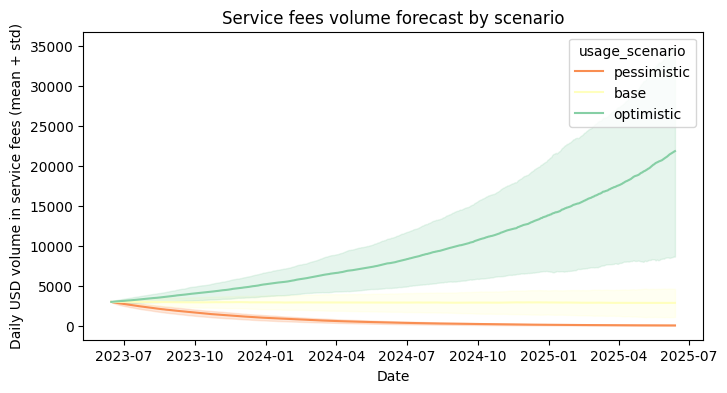

In [8]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=scenarios_df, x="date", y="service_fees", hue="usage_scenario", errorbar="sd", palette="Spectral")
plt.title("Service fees volume forecast by scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily USD volume in service fees (mean + std)")
plt.show()

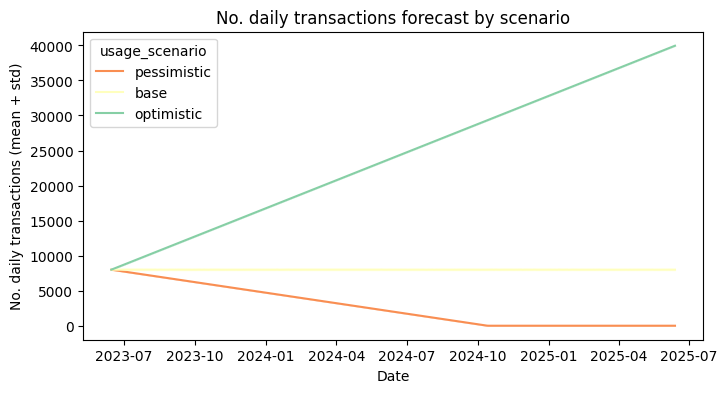

In [9]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=scenarios_df, x="date", y="n_txs", hue="usage_scenario", errorbar="sd", palette="Spectral")
plt.title("No. daily transactions forecast by scenario") 
plt.xlabel("Date") 
plt.ylabel("No. daily transactions (mean + std)")
plt.show()

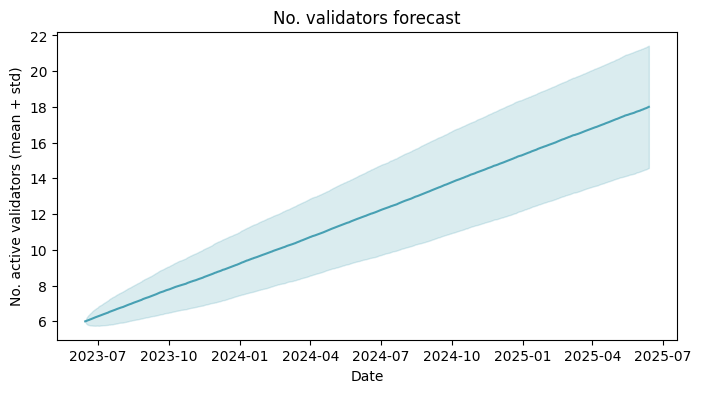

In [10]:
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=scenarios_df, x="date", y="n_validators", errorbar="sd", c='#47a0b3')
plt.title("No. validators forecast") 
plt.xlabel("Date") 
plt.ylabel("No. active validators (mean + std)")
plt.show()